<a href="https://colab.research.google.com/github/StevenGeorge777/Python_codes/blob/main/Final_code_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [ ]:
#data = pd.ExcelFile('Master FIle.xlsx')
df_model = pd.read_excel('Master FIle.xlsx')

In [ ]:
# df_model = df_model[df_model['Terminal Name'].str.contains('Melamathur')]
df_model = df_model[df_model['Terminal'].str.contains('Melamathur')]

first_sale_date = df_model[df_model['QtyInKgsSum'] != 0]['sales_date'].min()
df_terminal = df_model[df_model['sales_date'] >= first_sale_date]
df_terminal.reset_index(drop=True, inplace=True)

non_zero_sales = df_terminal[df_terminal['QtyInKgsSum'] != 0]
top_skus = non_zero_sales['sku_id'].value_counts().head(5)

most_sold_sku = top_skus.index[0]
df = df_terminal[df_terminal['sku_id'] == 1]
df.reset_index(drop=True, inplace=True)
df.drop(columns=['sku_id', 'Wastage', 'Stock'], inplace=True)
# df.drop(columns = ['Unnamed: 5', 'Unnamed: 6','Unnamed: 7'], inplace=True)
print(df)

      Terminal sales_date  QtyInKgsSum  Despatch
0   Melamathur 2024-02-22        6.575     16.50
1   Melamathur 2024-02-23        7.800     12.39
2   Melamathur 2024-02-24        5.270     12.00
3   Melamathur 2024-02-25        5.600     12.00
4   Melamathur 2024-02-26        1.015      7.00
..         ...        ...          ...       ...
64  Melamathur 2024-04-26        0.835      5.01
65  Melamathur 2024-04-27        1.215      5.12
66  Melamathur 2024-04-28        2.110      6.10
67  Melamathur 2024-04-29        1.005      5.36
68  Melamathur 2024-04-30        3.220      6.01

[69 rows x 4 columns]


<ipython-input-8-bc0d05765690>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['sku_id', 'Wastage', 'Stock'], inplace=True)


We can put two for loops here to get all skus for all terminals.

In the below code we have split the the data into two data frames. One with 51 data points (day 1 to 51) and other with 13 data points (day 52 to day 64). We have found forecast for day 52 and 53 i.e. t+1 and t+2 days. so we compare the forecast we got for 52 and 53 day with the actual values of the second data frame having actual values from (day 52 to 64).

In [ ]:
# Split the data into training and testing sets (80% for training, 20% for testing)
split_ratio = 0.8
train_size = int(len(df) * split_ratio)
train_data = df[:train_size]
test_data = df[train_size-1:]
actualsalesdata_for_findingerror =df[:train_size+2]

#Train Data Forecasting

# Get the 25th and 75th percentiles
q1 = train_data['QtyInKgsSum'].quantile(0.25)
q3 = train_data['QtyInKgsSum'].quantile(0.75)

train_data['sales_date'] = pd.to_datetime(train_data['sales_date'])

# List to store new rows
new_rows = []

# Calculate average of the last 3 actual demand values
last_3_demands = train_data['QtyInKgsSum'].tail(3)  # Get last 3 values
mean_last_3_demand = last_3_demands.mean()          # Calculate the mean

# Get the last date
last_date = train_data['sales_date'].max()

# --- Row 1: Average of Last 3 Demands ---
new_row_mean = {
    'Terminal': train_data['Terminal'].iloc[0],
    'sales_date': last_date + pd.to_timedelta(1, unit='D'),
    'QtyInKgsSum': mean_last_3_demand,  # Use the average of last 3
    'Despatch': test_data['Despatch'].iloc[1]  # Use the first value from the test data
}
new_rows.append(new_row_mean)

# --- Row 2: NaN Values ---
new_row_nan = {
    'Terminal': train_data['Terminal'].iloc[0],  # NaN for terminal
    'sales_date': last_date + pd.to_timedelta(2, unit='D'),  # Two days ahead
    'QtyInKgsSum': 0,
    'Despatch': test_data['Despatch'].iloc[2]  # Use the second value from the test data
}
new_rows.append(new_row_nan)

# Create a dataframe from the new rows
new_df = pd.DataFrame(new_rows)

# Append the new rows to the original dataframe
train_data = pd.concat([train_data, new_df]).sort_values('sales_date').reset_index(drop=True)

def expo_value(qty):
  if qty < q1:
    return q1
  elif qty > q3:
    return q3
  else:
    return qty

# Create a new dataframe 'expo'
# expo = train_data[['Terminal', 'sales_date']].copy()
# expo['QtyInKgsSum'] = train_data['QtyInKgsSum'].apply(expo_value)
expo = train_data[['Terminal', 'sales_date', 'QtyInKgsSum']].copy()

# Apply the expo_value function to all rows except the first
expo['QtyInKgsSum'].iloc[1:] = expo['QtyInKgsSum'].iloc[1:].apply(expo_value)



def calculate_mse(alpha, data):

    window_size = 7  # Fixed window size
    num_windows = len(data) - window_size + 1  # Number of possible windows
    mse_values = []  # List to store MSE for each window
    total_mse = 0

    for i in range(num_windows):
        actual = data.iloc[i:i + window_size]  # Get the current window of actual values

        # Initialize forecast with the first value
        forecast = pd.Series([actual.iloc[0]] * window_size)
        for j in range(1, window_size):
            forecast.iloc[j] = alpha * actual.iloc[j - 1] + (1 - alpha) * forecast.iloc[j - 1]

        mse = mean_squared_error(actual, forecast)
        # mse = np.mean((actual - forecast)**2)
        # print(mse)
        mse_values.append(mse)

    total_mse = sum(mse_values)
    return total_mse/num_windows # Return the average MSE over all windows

# Optimization using np.arange to generate alpha values
expo_alpha = 0
expo_mse = float('inf')  # Initialize with a large value

for alpha in np.arange(0.1, 1.1, 0.1):  # Step 0.1 from 0.1 to 1
    mse_1 = calculate_mse(alpha, expo['QtyInKgsSum'])
    if mse_1 < expo_mse:
        expo_alpha = alpha
        expo_mse = mse_1
    else:
      continue

def expo_model_initial(alpha, data):

  expo_forecast = data.copy()
  expo_forecast = expo_forecast.to_frame().reset_index() # Convert the series to a dataframe
  expo_forecast.columns = ['sales_date', 'QtyInKgsSum'] # Name the columns

  # Initial forecast (can be set to the first data point or average)
  forecast = expo_forecast["QtyInKgsSum"].iloc[0] # Access QtyInKgsSum column
  expo_forecast["Forecast"] = forecast

  # Iterate through data using enumerate to access both index and value
  # for i, qty in enumerate(expo_forecast["QtyInKgsSum"]):
  #     forecast = alpha * qty + (1 - alpha) * forecast
  #     #forecast = forecast + alpha * (qty - forecast)
  #     expo_forecast.loc[i, "Forecast"] = forecast
  for i in range(1, len(expo_forecast)):
        qty = expo_forecast["QtyInKgsSum"].iloc[i]
        forecast = alpha * qty + (1 - alpha) * forecast
        expo_forecast.loc[i, "Forecast"] = forecast

  return expo_forecast['Forecast'].tolist() # Return the forecast as a list


final_forecasts = expo_model_initial(expo_alpha, expo['QtyInKgsSum'])

expo_forecast_train = pd.DataFrame.from_dict({"Terminal":expo['Terminal'], "Date":expo['sales_date'],"Demand":expo['QtyInKgsSum'], "Forecast": final_forecasts})

 # Filtering values below 25%

def croston_value_25(qty):
  if qty < q1:
    return q1 - qty
  else:
    return 0.00

# Create a new dataframe 'croston_25'
# croston_25 = train_data[['Terminal', 'sales_date']].copy()
# croston_25['QtyInKgsSum'] = train_data['QtyInKgsSum'].apply(croston_value_25)

croston_25 = train_data[['Terminal', 'sales_date', 'QtyInKgsSum']].copy()

# Apply the expo_value function to all rows except the first
croston_25['QtyInKgsSum'].iloc[1:] = croston_25['QtyInKgsSum'].iloc[1:].apply(croston_value_25)

# Filtering values above 75%

def croston_value_75(qty):
  if qty > q3:
    return qty - q3
  else:
    return 0.00

# Create a new dataframe 'croston_75'
# croston_75 = train_data[['Terminal', 'sales_date']].copy()
# croston_75['QtyInKgsSum'] = train_data['QtyInKgsSum'].apply(croston_value_75)

croston_75 = train_data[['Terminal', 'sales_date', 'QtyInKgsSum']].copy()

# Apply the expo_value function to all rows except the first
croston_75['QtyInKgsSum'].iloc[1:] = croston_75['QtyInKgsSum'].iloc[1:].apply(croston_value_75)

def croston(alpha, beta, ts):

    d = ts.values  # Convert pandas Series to NumPy array
    cols = len(d)

    a = np.full(cols, np.nan)  # Level
    p = np.full(cols, np.nan)  # Period
    f = np.full(cols, np.nan)  # Forecast
    q = 1  # Periods since last demand observation

    # Initialization (adjusting for window indexing)
    first_occurrence = np.argmax(d > 0)
    a[0] = d[first_occurrence]
    p[0] = 1 + first_occurrence
    f[0] = a[0] / p[0]

    # Create forecasts
    for t in range(cols - 1):
        if d[t] > 0:
            a[t + 1] = alpha * d[t] + (1 - alpha) * a[t]
            p[t + 1] = beta * q + (1 - beta) * p[t]
            f[t + 1] = a[t + 1] / p[t + 1]
            q = 1
        else:
            a[t + 1] = a[t]
            p[t + 1] = p[t]
            f[t + 1] = f[t]
            q += 1

    # Calculate MSE
    mse = mean_squared_error(d, f)
    return mse



def croston_rolling_pandas(df, alpha, beta, window_size=7):

    mse_values = []
    for i in range(len(df) - window_size + 1):
        window = df['QtyInKgsSum'].iloc[i:i + window_size]
        mse = croston(alpha, beta, window)
        mse_values.append(mse)

    return np.mean(mse_values)  # Return the average MSE over all windows

# Optimization
cros25_alpha = 0
cros25_beta = 0
cros25_mse = float('inf')

for alpha in np.arange(0.1, 1.1, 0.1):
    for beta in np.arange(0.1, 1.1, 0.1):
        mse = croston_rolling_pandas(croston_25, alpha, beta)  # Call the modified function
        if mse < cros25_mse:
            cros25_alpha = alpha
            cros25_beta = beta
            cros25_mse = mse

# Optimization
cros75_alpha = 0
cros75_beta = 0
cros75_mse = float('inf')

for alpha in np.arange(0.1, 1.1, 0.1):
    for beta in np.arange(0.1, 1.1, 0.1):
        mse = croston_rolling_pandas(croston_75, alpha, beta)  # Call the modified function
        if mse < cros75_mse:
            cros75_alpha = alpha
            cros75_beta = beta
            cros75_mse = mse

def croston_model(alpha, beta, ts):

    d = ts.values  # Convert pandas Series to NumPy array
    cols = len(d)

    a = np.full(cols, np.nan)  # Level
    p = np.full(cols, np.nan)  # Period
    f = np.full(cols, np.nan)  # Forecast
    q = 1  # Periods since last demand observation

    # Initialization (adjusting for window indexing)
    first_occurrence = np.argmax(d > 0)
    a[0] = d[first_occurrence]
    p[0] = 1 + first_occurrence
    f[0] = a[0] / p[0]

    # Create forecasts
    for t in range(cols - 1):
        if d[t] > 0:
            a[t + 1] = alpha * d[t] + (1 - alpha) * a[t]
            p[t + 1] = beta * q + (1 - beta) * p[t]
            f[t + 1] = a[t + 1] / p[t + 1]
            q = 1
        else:
            a[t + 1] = a[t]
            p[t + 1] = p[t]
            f[t + 1] = f[t]
            q += 1


    df = pd.DataFrame.from_dict({"Demand":d,"Forecast":f,"Period":p,"Level":a,"Error":d-f}) # Use the original demand array 'd'
    return df

def croston_window(df, date, alpha, beta, window_size=7):
  results = []  # Initialize a list to store results from each window
  # Rename 'QtyInKgsSum' to 'Demand' in the entire DataFrame
  df = df.rename(columns={'QtyInKgsSum': 'Demand', 'sales_date': 'sales date'})
  forecast_df = df.iloc[:window_size-1].copy() # Initialize forecast_df by copying the first window_size rows.

  for i in range(len(df) - window_size + 1):
    window = df.iloc[i:i + window_size]  # Extract the rolling window
    # Select only the 'Demand' column for Croston calculations
    df_new = croston_model(alpha, beta, window['Demand'])  # Pass only the 'Demand' column to croston

def Croston_model_train(ts,alpha, beta):
    d = np.array(ts) # Transform the input into a numpy array
    cols = len(d) # Historical period length


    #level (a), periodicity(p) and forecast (f)
    a,p,f = np.full((3,cols + 1),np.nan) #Increase the size of the arrays to accommodate the t+1 index
    q = 1 #periods since last demand observation

    # Initialization
    first_occurence = np.argmax(d[:cols] > 0)
    a[0] = d[first_occurence]
    p[0] = 1 + first_occurence
    f[0] = a[0]/p[0]
    # Create all the t+1 forecasts
    for t in range(0,cols):
        if d[t] > 0:
            a[t+1] = alpha*d[t] + (1-alpha)*a[t]
            p[t+1] = beta*q + (1-beta)*p[t]
            f[t+1] = a[t+1]/p[t+1]
            q = 1
        else:
            a[t+1] = a[t]
            p[t+1] = p[t]
            f[t+1] = f[t]
            q += 1


    df = pd.DataFrame.from_dict({"Demand":d,"Forecast":f[1:],"Period":p[1:],"Level":a[1:],"Error":d-f[1:]}) # Adjust the slicing to start from index 1
    return df

cros25_forecast_train = Croston_model_train(croston_25['QtyInKgsSum'], cros25_alpha, cros25_beta)

cros75_forecast_train = Croston_model_train(croston_75['QtyInKgsSum'], cros75_alpha, cros75_beta)

def combine(data, expo, cros25, cros75):

  final = data.copy()
  final['new_forecast'] = 0

  # Reset indices to ensure alignment
  expo = expo.reset_index(drop=True)
  cros25 = cros25.reset_index(drop=True)
  cros75 = cros75.reset_index(drop=True)
  final = final.reset_index(drop=True)

  for index, row in expo.iterrows():
    ex = row['Forecast']
    cr25 = cros25.loc[index, 'Forecast']
    cr75 = cros75.loc[index, 'Forecast']
    final.loc[index, 'new_forecast'] = abs(ex - cr25 + cr75)
    # final.loc[index, 'new_forecast'] =cr75

  return final

# actualsalesdata_for_findingerror = actualsalesdata_for_findingerror.rename(columns = {'QtyInKgsSum':'actualsalesdata_for_findingerror'})
model_train = combine(train_data, expo_forecast_train, cros25_forecast_train, cros75_forecast_train)
# model_train_combined = pd.concat([model_train,actualsalesdata_for_findingerror['actualsalesdata_for_findingerror']], axis = 1)
print(model_train)


<ipython-input-9-84a8b31dade1>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['sales_date'] = pd.to_datetime(train_data['sales_date'])
<ipython-input-9-84a8b31dade1>:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  expo['QtyInKgsSum'].iloc[1:] = expo['QtyInKgsSum'].iloc[1:].apply(expo_value)
<ipython-input-9-84a8b31dade1>:145: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a

      Terminal sales_date  QtyInKgsSum  Despatch  new_forecast
0   Melamathur 2024-02-22     6.575000     16.50      6.575000
1   Melamathur 2024-02-23     7.800000     12.39      3.164500
2   Melamathur 2024-02-24     5.270000     12.00      0.169650
3   Melamathur 2024-02-25     5.600000     12.00      0.578085
4   Melamathur 2024-02-26     1.015000      7.00      3.386717
5   Melamathur 2024-02-27     1.505000      5.00      2.991538
6   Melamathur 2024-02-28     2.050000      5.00      3.160466
7   Melamathur 2024-02-29     3.035000      5.00      3.819037
8   Melamathur 2024-03-01     1.525000      2.80      3.176466
9   Melamathur 2024-03-02     2.480000      3.08      3.492437
10  Melamathur 2024-03-03     0.890000      1.25      3.523376
11  Melamathur 2024-03-04     0.425000      0.36      0.367971
12  Melamathur 2024-03-05     3.220000      3.82      1.421874
13  Melamathur 2024-03-06     2.570000      5.00      1.453434
14  Melamathur 2024-03-07     2.105000      5.00      1

<ipython-input-9-84a8b31dade1>:329: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '6.575' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final.loc[index, 'new_forecast'] = abs(ex - cr25 + cr75)


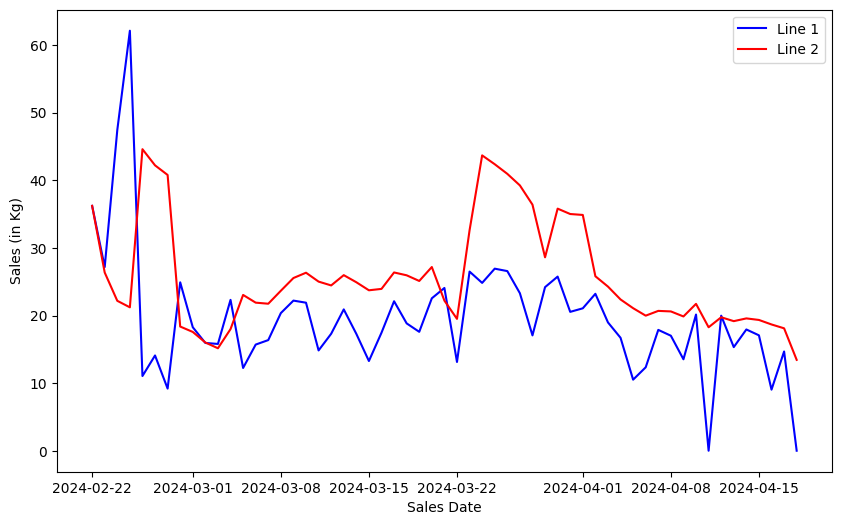

In [ ]:
y_values_1 = model_train['QtyInKgsSum']
y_values_2 = model_train['new_forecast']
# percentile_75 = model_train['Total Sales'].quantile(0.75)
# percentile_25 = model_train[''].quantile(0.25)
x_values = model_train['sales_date']
# plt.scatter(x_values, y_values)
# plt.axhline(y=percentile_75, color='r', linestyle='--')
# plt.axhline(y=percentile_25, color='r', linestyle='--')
# plt.show()
plt.figure(figsize=(10, 6))
plt.plot(x_values, y_values_1, color='blue', label='Line 1')  # First line in blue
plt.plot(x_values, y_values_2, color='red', label='Line 2')   # Second line in red
# Add labels and legend
plt.xlabel('Sales Date')
plt.ylabel('Sales (in Kg)')
plt.title('')
plt.legend()

# Show the plot
plt.show()

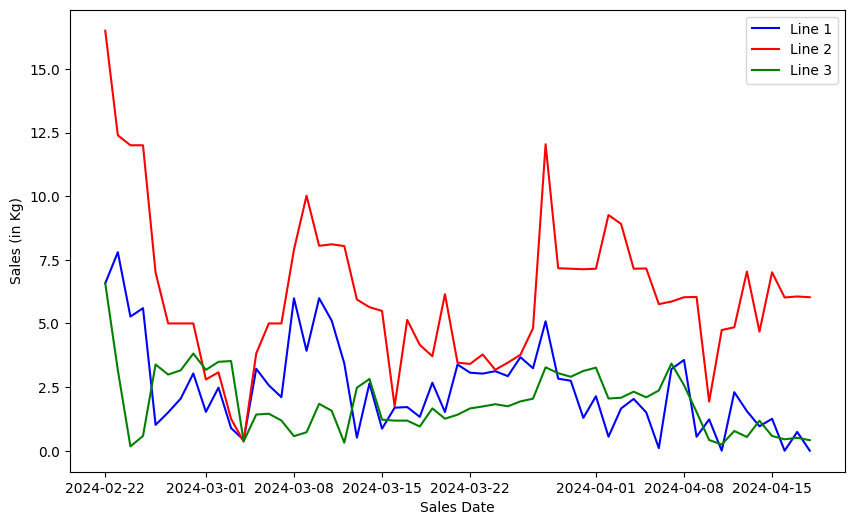

In [ ]:
y_values_1 = model_train['QtyInKgsSum']
y_values_2 = model_train['Despatch']
y_values_3 = model_train['new_forecast']
# percentile_75 = model_train['Total Sales'].quantile(0.75)
# percentile_25 = model_train[''].quantile(0.25)
x_values = model_train['sales_date']
# plt.scatter(x_values, y_values)
# plt.axhline(y=percentile_75, color='r', linestyle='--')
# plt.axhline(y=percentile_25, color='r', linestyle='--')
# plt.show()
plt.figure(figsize=(10, 6))
plt.plot(x_values, y_values_1, color='blue', label='Line 1')  # First line in blue
plt.plot(x_values, y_values_2, color='red', label='Line 2')   # Second line in red
plt.plot(x_values, y_values_3, color='green', label='Line 3')   # Second line in red
# Add labels and legend
plt.xlabel('Sales Date')
plt.ylabel('Sales (in Kg)')
plt.title('')
plt.legend()

# Show the plot
plt.show()

In [ ]:
# # Split the data into training and testing sets (80% for training, 20% for testing)
# split_ratio = 0.8
# train_size = int(len(df) * split_ratio)
# train_data = df[:train_size]
# test_data = df[train_size-1:]

# #Train Data Forecasting

# # Get the 25th and 75th percentiles
# q1 = train_data['QtyInKgsSum'].quantile(0.25)
# q3 = train_data['QtyInKgsSum'].quantile(0.75)

# train_data['sales_date'] = pd.to_datetime(train_data['sales_date'])

# # List to store new rows
# new_rows = []

# # Calculate average of the last 3 actual demand values
# last_3_demands = train_data['QtyInKgsSum'].tail(3)  # Get last 3 values
# mean_last_3_demand = last_3_demands.mean()          # Calculate the mean

# # Get the last date
# last_date = train_data['sales_date'].max()

# # --- Row 1: Average of Last 3 Demands ---
# new_row_mean = {
#     'Terminal': train_data['Terminal'].iloc[0],
#     'sales_date': last_date + pd.to_timedelta(1, unit='D'),
#     'QtyInKgsSum': mean_last_3_demand,  # Use the average of last 3
#     'Despatch': test_data['Despatch'].iloc[1]  # Use the first value from the test data
# }
# new_rows.append(new_row_mean)

# # --- Row 2: NaN Values ---
# new_row_nan = {
#     'Terminal': train_data['Terminal'].iloc[0],  # NaN for terminal
#     'sales_date': last_date + pd.to_timedelta(2, unit='D'),  # Two days ahead
#     'QtyInKgsSum': 0,
#     'Despatch': test_data['Despatch'].iloc[2]  # Use the second value from the test data
# }
# new_rows.append(new_row_nan)

# # Create a dataframe from the new rows
# new_df = pd.DataFrame(new_rows)

# # Append the new rows to the original dataframe
# train_data = pd.concat([train_data, new_df]).sort_values('sales_date').reset_index(drop=True)

# def expo_value(qty):
#   if qty < q1:
#     return q1
#   elif qty > q3:
#     return q3
#   else:
#     return qty

# # Create a new dataframe 'expo'
# expo = train_data[['Terminal', 'sales_date']].copy()
# expo['QtyInKgsSum'] = train_data['QtyInKgsSum'].apply(expo_value)



# def calculate_mse(alpha, data):

#     window_size = 7  # Fixed window size
#     num_windows = len(data) - window_size + 1  # Number of possible windows
#     mse_values = []  # List to store MSE for each window
#     total_mse = 0

#     for i in range(num_windows):
#         actual = data.iloc[i:i + window_size]  # Get the current window of actual values

#         # Initialize forecast with the first value
#         forecast = pd.Series([actual.iloc[0]] * window_size)
#         for j in range(1, window_size):
#             forecast.iloc[j] = alpha * actual.iloc[j - 1] + (1 - alpha) * forecast.iloc[j - 1]

#         mse = mean_squared_error(actual, forecast)
#         # mse = np.mean((actual - forecast)**2)
#         # print(mse)
#         mse_values.append(mse)

#     total_mse = sum(mse_values)
#     return total_mse/num_windows # Return the average MSE over all windows

# # Optimization using np.arange to generate alpha values
# expo_alpha = 0
# expo_mse = float('inf')  # Initialize with a large value

# for alpha in np.arange(0.1, 1.1, 0.1):  # Step 0.1 from 0.1 to 1
#     mse_1 = calculate_mse(alpha, expo['QtyInKgsSum'])
#     if mse_1 < expo_mse:
#         expo_alpha = alpha
#         expo_mse = mse_1
#     else:
#       continue

# def expo_model_initial(alpha, data):

#   expo_forecast = data.copy()
#   expo_forecast = expo_forecast.to_frame().reset_index() # Convert the series to a dataframe
#   expo_forecast.columns = ['sales_date', 'QtyInKgsSum'] # Name the columns

#   # Initial forecast (can be set to the first data point or average)
#   forecast = expo_forecast["QtyInKgsSum"].iloc[0] # Access QtyInKgsSum column

#   # Iterate through data using enumerate to access both index and value
#   for i, qty in enumerate(expo_forecast["QtyInKgsSum"]):
#       forecast = alpha * qty + (1 - alpha) * forecast
#       #forecast = forecast + alpha * (qty - forecast)
#       expo_forecast.loc[i, "Forecast"] = forecast

#   return expo_forecast['Forecast'].tolist() # Return the forecast as a list


# final_forecasts = expo_model_initial(expo_alpha, expo['QtyInKgsSum'])

# expo_forecast_train = pd.DataFrame.from_dict({"Terminal":expo['Terminal'], "Date":expo['sales_date'],"Demand":expo['QtyInKgsSum'], "Forecast": final_forecasts})

#  # Filtering values below 25%

# def croston_value_25(qty):
#   if qty < q1:
#     return q1 - qty
#   else:
#     return 0.00

# # Create a new dataframe 'croston_25'
# croston_25 = train_data[['Terminal', 'sales_date']].copy()
# croston_25['QtyInKgsSum'] = train_data['QtyInKgsSum'].apply(croston_value_25)

# # Filtering values above 75%

# def croston_value_75(qty):
#   if qty > q3:
#     return qty - q3
#   else:
#     return 0.00

# # Create a new dataframe 'croston_75'
# croston_75 = train_data[['Terminal', 'sales_date']].copy()
# croston_75['QtyInKgsSum'] = train_data['QtyInKgsSum'].apply(croston_value_75)

# def croston(alpha, beta, ts):

#     d = ts.values  # Convert pandas Series to NumPy array
#     cols = len(d)

#     a = np.full(cols, np.nan)  # Level
#     p = np.full(cols, np.nan)  # Period
#     f = np.full(cols, np.nan)  # Forecast
#     q = 1  # Periods since last demand observation

#     # Initialization (adjusting for window indexing)
#     first_occurrence = np.argmax(d > 0)
#     a[0] = d[first_occurrence]
#     p[0] = 1 + first_occurrence
#     f[0] = a[0] / p[0]

#     # Create forecasts
#     for t in range(cols - 1):
#         if d[t] > 0:
#             a[t + 1] = alpha * d[t] + (1 - alpha) * a[t]
#             p[t + 1] = beta * q + (1 - beta) * p[t]
#             f[t + 1] = a[t + 1] / p[t + 1]
#             q = 1
#         else:
#             a[t + 1] = a[t]
#             p[t + 1] = p[t]
#             f[t + 1] = f[t]
#             q += 1

#     # Calculate MSE
#     mse = mean_squared_error(d, f)
#     return mse



# def croston_rolling_pandas(df, alpha, beta, window_size=7):

#     mse_values = []
#     for i in range(len(df) - window_size + 1):
#         window = df['QtyInKgsSum'].iloc[i:i + window_size]
#         mse = croston(alpha, beta, window)
#         mse_values.append(mse)

#     return np.mean(mse_values)  # Return the average MSE over all windows

# # Optimization
# cros25_alpha = 0
# cros25_beta = 0
# cros25_mse = float('inf')

# for alpha in np.arange(0.1, 1.1, 0.1):
#     for beta in np.arange(0.1, 1.1, 0.1):
#         mse = croston_rolling_pandas(croston_25, alpha, beta)  # Call the modified function
#         if mse < cros25_mse:
#             cros25_alpha = alpha
#             cros25_beta = beta
#             cros25_mse = mse

# # Optimization
# cros75_alpha = 0
# cros75_beta = 0
# cros75_mse = float('inf')

# for alpha in np.arange(0.1, 1.1, 0.1):
#     for beta in np.arange(0.1, 1.1, 0.1):
#         mse = croston_rolling_pandas(croston_75, alpha, beta)  # Call the modified function
#         if mse < cros75_mse:
#             cros75_alpha = alpha
#             cros75_beta = beta
#             cros75_mse = mse

# def croston_model(alpha, beta, ts):

#     d = ts.values  # Convert pandas Series to NumPy array
#     cols = len(d)

#     a = np.full(cols, np.nan)  # Level
#     p = np.full(cols, np.nan)  # Period
#     f = np.full(cols, np.nan)  # Forecast
#     q = 1  # Periods since last demand observation

#     # Initialization (adjusting for window indexing)
#     first_occurrence = np.argmax(d > 0)
#     a[0] = d[first_occurrence]
#     p[0] = 1 + first_occurrence
#     f[0] = a[0] / p[0]

#     # Create forecasts
#     for t in range(cols - 1):
#         if d[t] > 0:
#             a[t + 1] = alpha * d[t] + (1 - alpha) * a[t]
#             p[t + 1] = beta * q + (1 - beta) * p[t]
#             f[t + 1] = a[t + 1] / p[t + 1]
#             q = 1
#         else:
#             a[t + 1] = a[t]
#             p[t + 1] = p[t]
#             f[t + 1] = f[t]
#             q += 1


#     df = pd.DataFrame.from_dict({"Demand":d,"Forecast":f,"Period":p,"Level":a,"Error":d-f}) # Use the original demand array 'd'
#     return df

# def croston_window(df, date, alpha, beta, window_size=7):
#   results = []  # Initialize a list to store results from each window
#   # Rename 'QtyInKgsSum' to 'Demand' in the entire DataFrame
#   df = df.rename(columns={'QtyInKgsSum': 'Demand', 'sales_date': 'sales date'})
#   forecast_df = df.iloc[:window_size-1].copy() # Initialize forecast_df by copying the first window_size rows.

#   for i in range(len(df) - window_size + 1):
#     window = df.iloc[i:i + window_size]  # Extract the rolling window
#     # Select only the 'Demand' column for Croston calculations
#     df_new = croston_model(alpha, beta, window['Demand'])  # Pass only the 'Demand' column to croston

# def Croston_model_train(ts,alpha, beta):
#     d = np.array(ts) # Transform the input into a numpy array
#     cols = len(d) # Historical period length


#     #level (a), periodicity(p) and forecast (f)
#     a,p,f = np.full((3,cols + 1),np.nan) #Increase the size of the arrays to accommodate the t+1 index
#     q = 1 #periods since last demand observation

#     # Initialization
#     first_occurence = np.argmax(d[:cols] > 0)
#     a[0] = d[first_occurence]
#     p[0] = 1 + first_occurence
#     f[0] = a[0]/p[0]
#     # Create all the t+1 forecasts
#     for t in range(0,cols):
#         if d[t] > 0:
#             a[t+1] = alpha*d[t] + (1-alpha)*a[t]
#             p[t+1] = beta*q + (1-beta)*p[t]
#             f[t+1] = a[t+1]/p[t+1]
#             q = 1
#         else:
#             a[t+1] = a[t]
#             p[t+1] = p[t]
#             f[t+1] = f[t]
#             q += 1


#     df = pd.DataFrame.from_dict({"Demand":d,"Forecast":f[1:],"Period":p[1:],"Level":a[1:],"Error":d-f[1:]}) # Adjust the slicing to start from index 1
#     return df

# cros25_forecast_train = Croston_model_train(croston_25['QtyInKgsSum'], cros25_alpha, cros25_beta)

# cros75_forecast_train = Croston_model_train(croston_75['QtyInKgsSum'], cros75_alpha, cros75_beta)

# def combine(data, expo, cros25, cros75):

#   final = data.copy()
#   final['new_forecast'] = 0

#   # Reset indices to ensure alignment
#   expo = expo.reset_index(drop=True)
#   cros25 = cros25.reset_index(drop=True)
#   cros75 = cros75.reset_index(drop=True)
#   final = final.reset_index(drop=True)

#   for index, row in expo.iterrows():
#     ex = row['Forecast']
#     cr25 = cros25.loc[index, 'Forecast']
#     cr75 = cros75.loc[index, 'Forecast']
#     final.loc[index, 'new_forecast'] = ex - cr25 + cr75
#     # final.loc[index, 'new_forecast'] = cr75

#   return final

# model_train = combine(train_data, expo_forecast_train, cros25_forecast_train, cros75_forecast_train)
# print(model_train)


<ipython-input-6-b63903252027>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['sales_date'] = pd.to_datetime(train_data['sales_date'])


   Terminal sales_date  QtyInKgsSum  Despatch  new_forecast
0   Sithali 2024-02-26       14.915      0.00     19.127083
1   Sithali 2024-02-27       35.175     57.00     24.155708
2   Sithali 2024-02-28       50.025     54.33     27.213921
3   Sithali 2024-02-29       41.200     53.67     26.403436
4   Sithali 2024-03-01       18.435     24.17     30.347612
5   Sithali 2024-03-02       22.430     24.17     22.847022
6   Sithali 2024-03-03       23.330     24.17     24.168501
7   Sithali 2024-03-04       22.390     23.82     24.472694
8   Sithali 2024-03-05       19.810     23.82     23.368828
9   Sithali 2024-03-06       28.240     29.04     23.527636
10  Sithali 2024-03-07       34.645     38.21     28.058779
11  Sithali 2024-03-08       33.205     37.69     28.410122
12  Sithali 2024-03-09       30.855     37.10     26.870524
13  Sithali 2024-03-10       28.195     32.64     24.546645
14  Sithali 2024-03-11       30.165     40.18     25.228482
15  Sithali 2024-03-12       13.620     

<ipython-input-6-b63903252027>:309: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '19.127083333333328' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final.loc[index, 'new_forecast'] = ex - cr25 + cr75
